# Partition of feature space by random forest

In [293]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'retina'

from sklearn import tree
from dtreeviz.trees import *
from dtreeviz.models.sklearn_decision_trees import ShadowSKDTree


In [299]:
wine = load_wine()
X = wine.data
X = X[:,[12,6]]
y = wine.target
len(X), len(y)

colors = {'classes':
          [None, # 0 classes
          None, # 1 class
          ["#FEFEBB","#a1dab4"], # 2 classes
          ["#FEFEBB","#D9E6F5",'#a1dab4'], # 3
          ]
         }

feature_c_bivar = ['proline','flavanoid']
target_c_bivar = "wine"
class_name_bivar = list(wine.target_names)
feature_c_bivar, target_c_bivar,  class_name_bivar

(['proline', 'flavanoid'], 'wine', ['class_0', 'class_1', 'class_2'])

## Decision tree

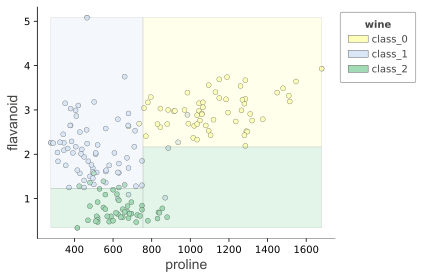

In [300]:
dtc_bivar = DecisionTreeClassifier(max_depth=2)
dtc_bivar.fit(X, y)

ctreeviz_bivar(dtc_bivar, X, y, 
               feature_names=feature_c_bivar, target_name=target_c_bivar, class_names=class_name_bivar,
               show={'splits', "legend"}, 
               colors={'scatter_edge': 'black'})
plt.tight_layout()
plt.show()

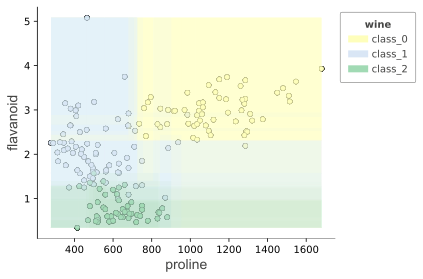

In [301]:
rf = RandomForestClassifier(n_estimators=10, min_samples_leaf=3, n_jobs=-1)
rf.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(6,4))
for i in range(len(rf.estimators_)):
    ctreeviz_bivar(rf.estimators_[i], X, y,
                   feature_names=feature_c_bivar, target_name=target_c_bivar, class_names=class_name_bivar,
                   show={'splits', "legend"}, 
                   colors={'scatter_edge': 'black',
                           'tesselation_alpha':.1,
                           'rect_edge':None},
                   ax=ax)
plt.tight_layout()
plt.show()

In [302]:
import tsensor

In [303]:
rf.predict_proba(X)[0:5]

array([[1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.82642857, 0.17357143, 0.        ]])

In [304]:
from dtreeviz.colors import color_blind_friendly_colors
from PIL import ImageColor
rgb = np.array([ImageColor.getcolor(c, mode="RGB") for c in color_blind_friendly_colors[3]])
rgb # 3 x 3 rgb for each class' color

array([[254, 254, 187],
       [217, 230, 245],
       [161, 218, 180]])

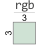

In [305]:
with tsensor.explain():
    rgb

In [306]:
# multiply each probability vector times rgb color for each class then add together to get weighted color
(rf.predict_proba(X) @ rgb)[0:10]

array([[254.        , 254.        , 187.        ],
       [254.        , 254.        , 187.        ],
       [254.        , 254.        , 187.        ],
       [254.        , 254.        , 187.        ],
       [247.57785714, 249.83428571, 197.06714286],
       [254.        , 254.        , 187.        ],
       [252.94285714, 253.31428571, 188.65714286],
       [252.94285714, 253.31428571, 188.65714286],
       [254.        , 254.        , 187.        ],
       [254.        , 254.        , 187.        ]])

In [307]:
from colour import Color
foo = (rf.predict_proba(X) @ rgb)[0:10] / 255 # to 0..1
[Color(rgb=x) for x in foo]

[<Color #fefebb>,
 <Color #fefebb>,
 <Color #fefebb>,
 <Color #fefebb>,
 <Color #f8fac5>,
 <Color #fefebb>,
 <Color #fdfdbd>,
 <Color #fdfdbd>,
 <Color #fefebb>,
 <Color #fefebb>]

In [450]:
import colour
from dtreeviz.colors import color_blind_friendly_colors
from dtreeviz.colors import adjust_colors
from PIL import ImageColor
GREY = '#444443'

def rfviz_bivar(model, X, y, npoints=100, nshades=200, colors=None,
                tile_fraction=.88, boundary_markersize=.8,
                show_proba=True, ax=None):
    if ax is None:
        fig,ax = plt.subplots(1,1, figsize=(4.5,4.8))

    class_values = np.unique(y)
    nclasses = len(class_values)
    
    X1 = X[:,0]
    X2 = X[:,1]
    x1range=(min(X1), max(X1))
    x2range=(min(X2), max(X2))
    w = np.diff(np.linspace(*x1range,num=npoints))[0]
    h = np.diff(np.linspace(*x2range,num=npoints))[0]
    w *= tile_fraction
    h *= tile_fraction

    # Make sure we have one tile around border so instance circles don't overflow
    x1range=(min(X1)-w, max(X1)+w)
    x2range=(min(X2)-h, max(X2)+h)

    gridpoints = [] # a list of coordinate pairs for the grid
    # Iterate through v1 (x-axis) most quickly then v2 (y-axis)
    for iv2,v2 in enumerate(np.linspace(*x2range,num=npoints)):
        for iv1,v1 in enumerate(np.linspace(*x1range,num=npoints)):
            gridpoints.append([v1,v2])
    gridpoints = np.array(gridpoints)

    grid_proba = model.predict_proba(gridpoints)
    y_pred = np.argmax(grid_proba, axis=1)

    # Get class to color map
    colors = adjust_colors(colors)
    color_values = colors['classes'][nclasses]
    color_map = {v: color_values[i] for i, v in enumerate(class_values)}
    # multiply each probability vector times rgb color for each class then add
    # together to get weighted color
    rgb = np.array([ImageColor.getcolor(c, mode="RGB") for c in color_values])    
    mycolors = grid_proba @ rgb
    mycolors /= 255 # get in [0..1]
    mycolors = [Color(rgb=c).hex for c in mycolors]
    y_pred_color = np.array(color_blind_friendly_colors[nclasses])[y_pred]
    
    # Draw probabilities or class prediction grid
    facecolors = mycolors if show_proba else y_pred_color
    boxes = []
    for i,(v1,v2) in enumerate(gridpoints):
        # center a box over (v1,v2) grid location
        rect = patches.Rectangle((v1-w/2, v2-h/2), w, h, angle=0.0, linewidth=0,
                                 facecolor=facecolors[i], alpha=1.0)
        boxes.append(rect)
    ax.add_collection(PatchCollection(boxes, match_original=True)) # MUCH faster than repeated add_patch()

    # Draw boundary locations
    # Get grid with class predictions with coordinates (x,y)
    # e.g., y_pred[0,0] is lower left pixel and y_pred[5,5] is top-right pixel
    # for npoints=5
    y_pred = y_pred.reshape(npoints,npoints)    # view as matrix
    dx = np.diff(y_pred, axis=1) # find transitions from one class to the other moving horizontally
    dx = np.abs(dx)
    dx = np.hstack([np.zeros((npoints,1)), dx]) # put a zero col vector on the left to restore size
    dy = np.diff(y_pred, axis=0) # find transitions moving vertically
    dy = np.abs(dy)
    dy = np.vstack([np.zeros((1,npoints)), dy]) # put a zero row vector on the top to restore size
    xydiffs = dx+dy                             # combine left right and up down transitions
    dx_edge_idx = np.where(dx.reshape(-1))      # what are the indexes of class transitions?
    dy_edge_idx = np.where(dy.reshape(-1))      # what are the indexes of class transitions?
    dx_edges = gridpoints[dx_edge_idx]          # get v1,v2 coordinates of left-to-right transitions
    dy_edges = gridpoints[dy_edge_idx]          # get v1,v2 coordinates of bottom-to-top transitions
    ax.plot(dx_edges[:,0]-w/2, dx_edges[:,1], 's', markersize=boundary_markersize, c=GREY, alpha=1.0)
    ax.plot(dy_edges[:,0], dy_edges[:,1]-h/2, 's', markersize=boundary_markersize, c=GREY, alpha=1.0)

    # Draw the X instances circles
    dot_w = 25
    X_hist = [X[y == cl] for cl in class_values]
    for i, h in enumerate(X_hist):
        ax.scatter(h[:, 0], h[:, 1], marker='o', s=dot_w, c=color_map[i],
                   edgecolors=colors['scatter_edge'], lw=.5, alpha=1.0)

    ax.spines['top'].set_visible(False)    # turns off the top "spine" completely
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)
    #     ax.set_xlim(*x1range)
    #     ax.set_ylim(*x2range)
    
    return

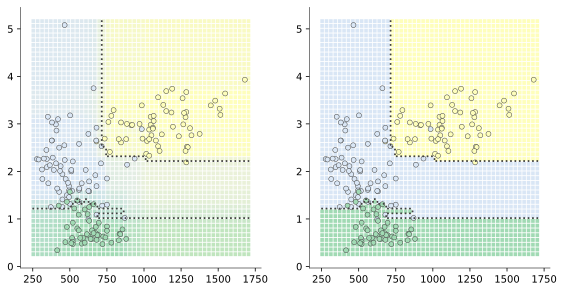

In [452]:
rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=2, n_jobs=-1)
rf.fit(X, y)

fig,axes = plt.subplots(1,2, figsize=(9.5,4.8), dpi=300)
rfviz_bivar(rf, X, y, npoints=50, ax=axes[0], tile_fraction=.85, show_proba=True)
rfviz_bivar(rf, X, y, npoints=50, ax=axes[1], tile_fraction=.85, show_proba=False)
plt.show()

(278.0, 1680.0) (0.34, 5.08)


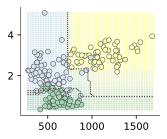

In [441]:
fig,ax = plt.subplots(1,1, figsize=(2.5,2))
rfviz_bivar(rf, X, y, npoints=50, ax=ax, tile_fraction=.8, boundary_markersize=.2, show_proba=True)

In [254]:
npoints = 3
x1range=max(X1) - min(X1)
x2range=max(X2) - min(X2)
w = x1range / npoints
h = x2range / npoints
x1range=(min(X1), max(X1))
x2range=(min(X2), max(X2))
print("w,h", w,h)

x1range, np.linspace(*x1range,num=npoints), np.diff(np.linspace(*x1range,num=npoints))

w,h 467.3333333333333 1.58


((278.0, 1680.0), array([ 278.,  979., 1680.]), array([701., 701.]))

In [255]:
x2range, np.linspace(*x2range,num=npoints), np.diff(np.linspace(*x2range,num=npoints))

((0.34, 5.08), array([0.34, 2.71, 5.08]), array([2.37, 2.37]))

w,h 12.037373737373741 0.040696969696969724


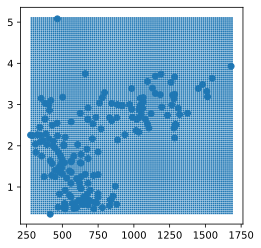

In [296]:
npoints = 100
X1 = X[:,0]
X2 = X[:,1]
x1range=max(X1) - min(X1)
x2range=max(X2) - min(X2)
# w = x1range / npoints
# h = x2range / npoints
x1range=(min(X1), max(X1))
x2range=(min(X2), max(X2))
w = np.diff(np.linspace(*x1range,num=npoints))[0]
h = np.diff(np.linspace(*x2range,num=npoints))[0]

w *= .85
h *= .85

print("w,h", w,h)

gridpoints = [] # a list of coordinate pairs for the grid
# Iterate through v1 (x-axis) most quickly then v2 (y-axis)
for iv2,v2 in enumerate(np.linspace(*x2range,num=npoints)):
    for iv1,v1 in enumerate(np.linspace(*x1range,num=npoints)):
        gridpoints.append([v1,v2])
gridpoints = np.array(gridpoints)

fig, ax = plt.subplots(1,1,figsize=(4,4))

boxes = []
for (x,y) in gridpoints:
    rect = patches.Rectangle((x, y), w, h, angle=0.0, linewidth=1, facecolor='orange', alpha=.5)
    boxes.append(rect)
ax.add_collection(PatchCollection(boxes))


ax.scatter(X1, X2, marker='o')

plt.show()

## Titantic

In [ ]:
df = pd.read_csv("../data/titanic/titanic.csv")
df['Sex'] = np.where(df['Sex']=='male', 0, 1)
df.head().T

In [ ]:
X, y = df.drop(['Survived','Name','Ticket','Cabin','Embarked'], axis=1), df['Survived']
X['Age_na'] = X['Age'].isna()
X['Age'] = X['Age'].fillna(X['Age'].median(skipna=True))
X.T

In [ ]:
from rfpimp import *

rf = RandomForestClassifier(n_estimators=20, min_samples_leaf=3, n_jobs=-1)
rf.fit(X, y)

I = importances(rf, X, y)
plot_importances(I)

In [ ]:
# Pick Sex, Pclass
X = X[['Age','Fare']]
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1)
rf.fit(X, y)

fig, ax = plt.subplots(1,1, figsize=(6,4))
for i in range(len(rf.estimators_)):
    ctreeviz_bivar(rf.estimators_[i], X, y,
                   feature_names=['Age','Fare'], target_name="Survived",
                   class_names=['Perished','Survived'],
                   show={'splits', "legend"}, 
                   colors={'scatter_edge': 'black',
                           'tesselation_alpha':.1,
                          'rect_edge':None},
                   ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(4.5,4.5))
rfviz_bivar(rf, X.values, npoints=80, ax=ax, alpha=1.0, dotsize=2, padding=0.1, show_proba=True)
plt.show()

## cancer

In [ ]:
cancer = load_breast_cancer()

df = pd.DataFrame(data=cancer.data)
df.columns = [f'f{i}' for i in range(df.shape[1])]
df['y'] = cancer.target
df.head(3)

In [ ]:
X, y = df.drop('y',axis=1), df['y']

In [ ]:
rf = RandomForestClassifier(n_estimators=20, min_samples_leaf=3, n_jobs=-1)
rf.fit(X, y)

I = importances(rf, X, y)
plot_importances(I)

In [ ]:
# pick f27 and f7

In [ ]:
X = df[['f27','f7']]

rf = RandomForestClassifier(n_estimators=30, min_samples_leaf=5, n_jobs=-1)
rf.fit(X, y)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
for i in range(len(rf.estimators_)):
    ctreeviz_bivar(rf.estimators_[i], X, y,
                   feature_names=['f27','f7'], target_name="cancer",
                   class_names=['not-cancer','cancer'],
                   show={'splits', "legend"}, 
                   colors={'scatter_edge': 'black',
                           'tesselation_alpha':.05},
                   ax=ax)
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(1,1, figsize=(4.5,4.5))
rfviz_bivar(rf, X.values, npoints=80, ax=ax, alpha=1.0, dotsize=2, padding=0.1, show_proba=True)
plt.show()